# Loading Libraries

In [26]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline
sns.set_style("whitegrid")
sns.set(rc = {'figure.figsize':(15, 10)})

# Helper Functions

In [2]:
# function for creating a feature importance dataframe
def important_df(column_names, importances):
    df = pd.DataFrame({
            'feature': column_names,
            'feature_importance': importances
        }) \
        .sort_values('feature_importance', ascending=False) \
        .reset_index(drop=True)
    return df


# plotting a feature importance dataframe (horizontal barchart)
def important_plot(df, title):
    df.columns = ['feature', 'feature_importance']
    sns.barplot(
        x='feature_importance', y='feature', data=df, orient='h', color='royalblue'
    ).set_title(title, fontsize=20)

In [2]:
def save_model(model):
    pickle.dump(model, open("./assets/model.pkl", "wb"))


def load_model():
    return pickle.load(open("./assets/model.pkl", "rb"))

# Create Directory if Not Exist

In [3]:
import os

if not os.path.exists('assets'):
   os.makedirs('assets')

# Adult Census Income Dataset

In [4]:
# Encode dataset column to number base
def cleandata(dataset):
    dataset.drop("fnlwgt", axis = 1, inplace = True)
    for column in dataset.columns:
        MODE = dataset[column].mode()[0]
        dataset[column].fillna(MODE, inplace = True)
    for column in dataset.columns:
        if isinstance(dataset[column].dtype, object):
            LE = LabelEncoder()
            dataset[column] = LE.fit_transform(dataset[column])
    return dataset


# Split income and all others for features
def split_feature_class(dataset, feature):
    features = dataset.drop(feature, axis=1)
    labels = dataset[feature].copy()
    return features, labels

In [5]:
# https://www.kaggle.com/uciml/adult-census-income
dataset = pd.read_csv("./assets/adult.csv")
dataset.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [12]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education.num   32561 non-null  int64 
 5   marital.status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital.gain    32561 non-null  int64 
 11  capital.loss    32561 non-null  int64 
 12  hours.per.week  32561 non-null  int64 
 13  native.country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [14]:
dataset.describe().round(2)

,age,fnlwgt,education.num,capital.gain,capital.loss,hours.per.week
count,32561.00,32561.00,32561.00,32561.00,32561.00,32561.00
mean,38.58,189778.37,10.08,1077.65,87.30,40.44
std,13.64,105549.98,2.57,7385.29,402.96,12.35
min,17.00,12285.00,1.00,0.00,0.00,1.00
25%,28.00,117827.00,9.00,0.00,0.00,40.00
50%,37.00,178356.00,10.00,0.00,0.00,40.00
75%,48.00,237051.00,12.00,0.00,0.00,45.00
max,90.00,1484705.00,16.00,99999.00,4356.00,99.00


In [15]:
dataset.isna().sum()

age               0
workclass         0
fnlwgt            0
education         0
education.num     0
marital.status    0
occupation        0
relationship      0
race              0
sex               0
capital.gain      0
capital.loss      0
hours.per.week    0
native.country    0
income            0
dtype: int64

In [16]:
for feature in dataset.columns:
    print(f"{feature} = {dataset[dataset[feature] == '?'].shape[0]}")

age = 0
workclass = 1836
fnlwgt = 0
education = 0
education.num = 0
marital.status = 0
occupation = 1843
relationship = 0
race = 0
sex = 0
capital.gain = 0
capital.loss = 0
hours.per.week = 0
native.country = 583
income = 0


# Visualization

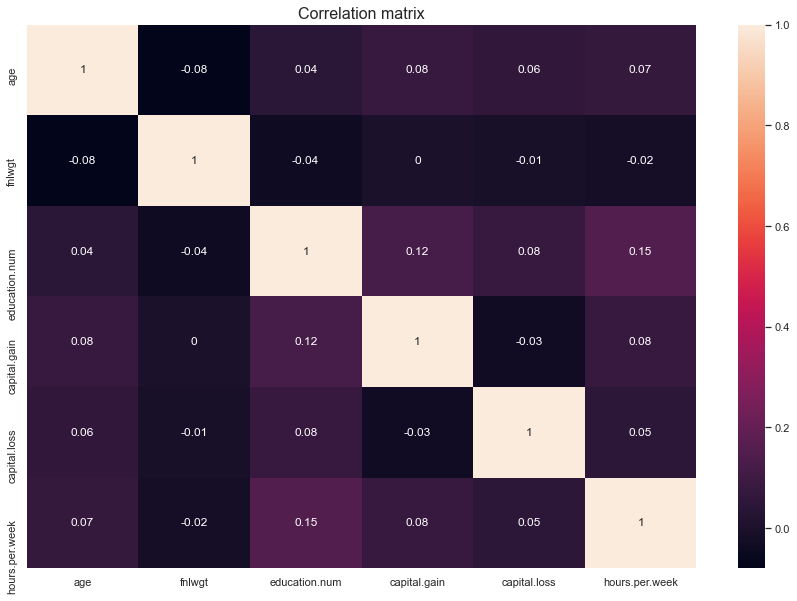

In [7]:
correlation = dataset.assign(target='>50k').corr().round(2)

sns.heatmap(correlation, annot=True).set_title('Correlation matrix', fontsize=16)
plt.show()

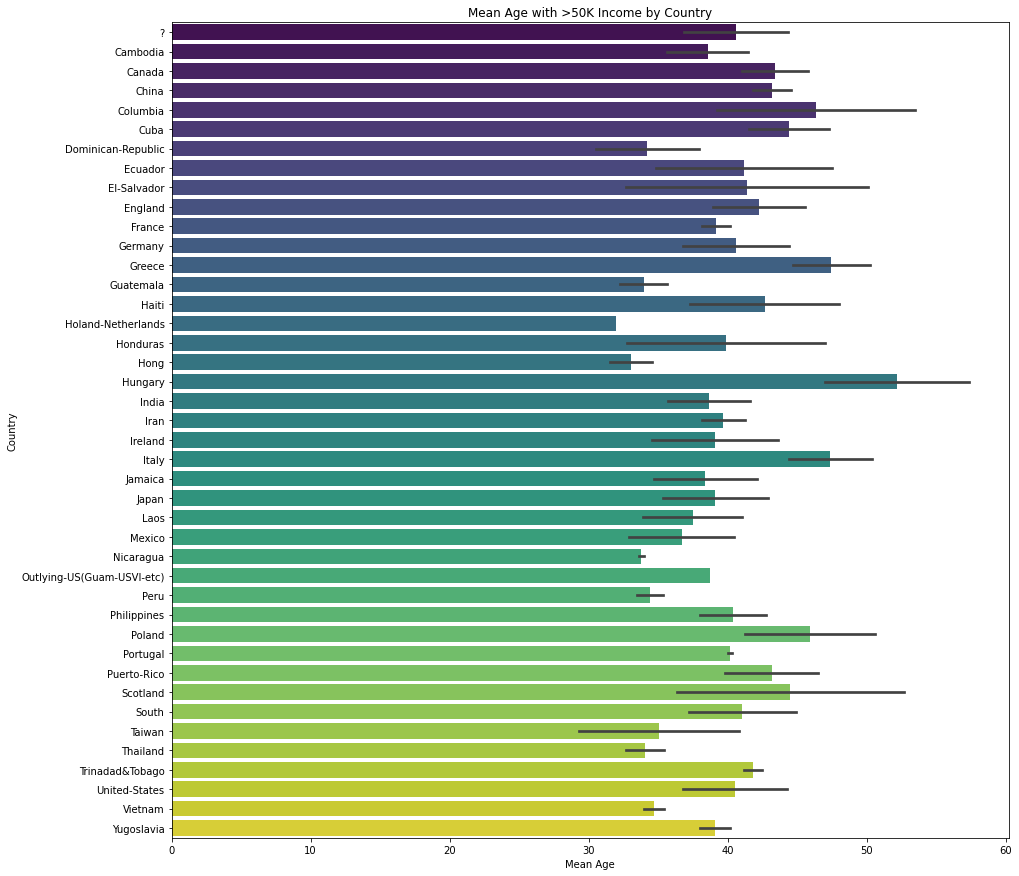

In [3]:
# average age and native country
rich = dataset[dataset["income"] == '>50K']
poor = dataset[dataset["income"] == '<=50K']

country_age_data = dataset[["native.country", "income", "age"]].groupby(["native.country", "income"]).mean()
country_age_data = country_age_data.reset_index()

plt.figure(figsize=(15, 15))
sns.barplot(x="age", y="native.country", data=country_age_data, palette="viridis")
plt.title("Mean Age with >50K Income by Country")
plt.xlabel("Mean Age")
plt.ylabel("Country")
plt.show()

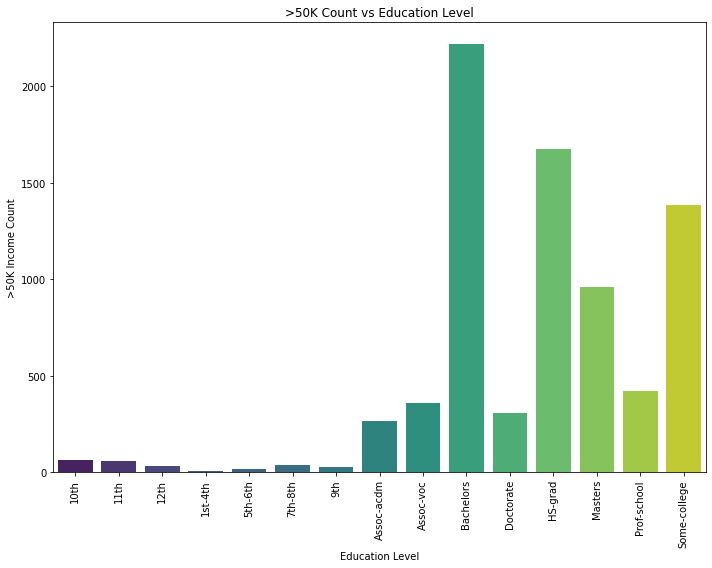

In [4]:
# education level
education_data = rich.groupby("education")["income"].count()
education_data = education_data.reset_index()

plt.figure(figsize=(10, 8))
sns.barplot(x="education", y="income", data=education_data, palette="viridis")
plt.title(">50K Count vs Education Level")
plt.xlabel("Education Level")
plt.ylabel(">50K Income Count")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

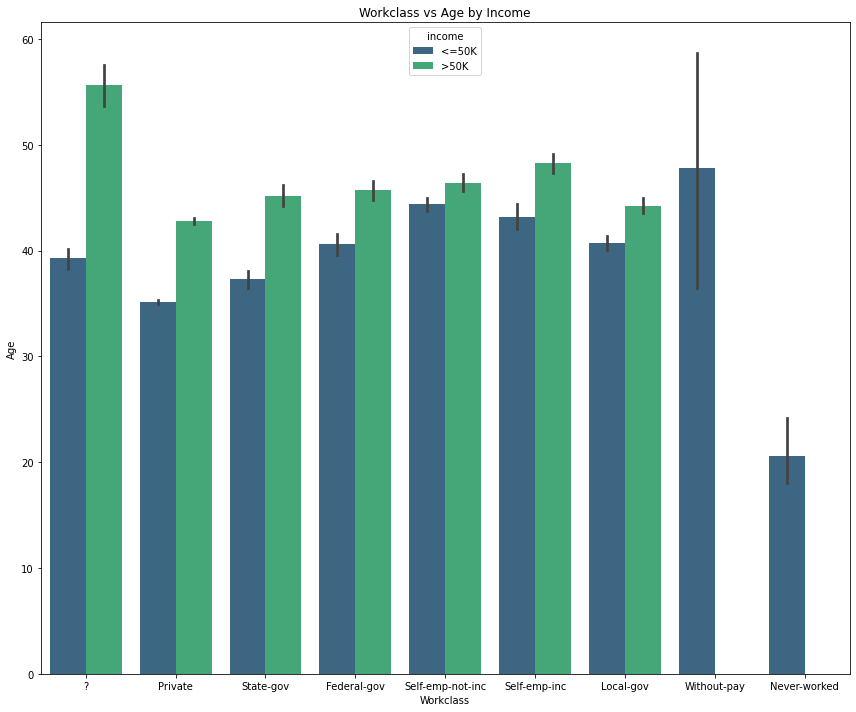

In [5]:
# workclasses and age by income
plt.figure(figsize=(12, 10))
sns.barplot(x="workclass", y="age", hue="income", data=dataset, palette="viridis")
plt.title("Workclass vs Age by Income")
plt.xlabel("Workclass")
plt.ylabel("Age")
plt.tight_layout()
plt.show()

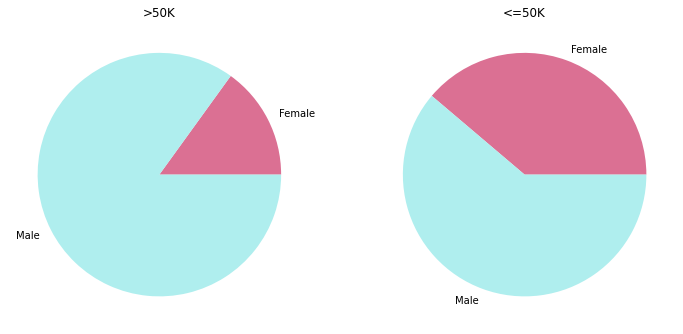

In [6]:
# male and female
gender_rich = rich[["sex", "income"]].groupby(["sex"]).count()
gender_rich = gender_rich.reset_index()

gender_poor = poor[["sex","income"]].groupby(["sex"]).count()
gender_poor = gender_poor.reset_index()

plt.figure(figsize=(12, 10))
plt.subplot(1, 2, 1)
plt.pie(x=gender_rich["income"], labels=["Female", "Male"], colors=["palevioletred", "paleturquoise"])
plt.title(">50K")

plt.subplot(1, 2, 2)
plt.pie(x=gender_poor["income"], labels=["Female", "Male"], colors=["palevioletred", "paleturquoise"])
plt.title("<=50K")
plt.show()

# Data Cleaning

In [8]:
dataset = cleandata(dataset)
dataset.sample(5)

,age,workclass,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
326,10,4,15,9,4,3,3,1,1,0,51,39,30,0
7926,5,4,15,9,4,8,2,4,1,0,0,24,39,0
10896,28,4,8,10,0,1,4,2,0,0,0,39,39,0
7987,24,2,15,9,2,12,0,4,1,0,0,39,39,0
19220,16,2,7,11,2,6,0,4,1,0,0,39,39,0


In [9]:
# train 80 % and test 20 %
train_set, test_set = train_test_split(dataset, test_size=0.2, random_state=123)

# train and test
train_features, train_labels = split_feature_class(train_set, "income")
test_features, test_labels = split_feature_class(test_set, "income")

# Features Importance

In [10]:
# find important features using RandomForrest
CLF = RandomForestClassifier(
    n_estimators=100,
    n_jobs=-1,
    oob_score=True,
    bootstrap=True,
    random_state=42
)

CLF.fit(train_features, train_labels)

RandomForestClassifier(n_jobs=-1, oob_score=True, random_state=42)

In [11]:
# overfitting in the model, as it performs much worse on OOB and worse on the validation
print(f"R2 Training Score: {CLF.score(train_features, train_labels):.2f}")
print(f"R2 Validation Score: {CLF.score(test_features, test_labels):.2f}")
print(f"OOB Score: {CLF.oob_score_:.2f}")

R2 Training Score: 0.98
R2 Validation Score: 0.84
OOB Score: 0.85


In [12]:
base = important_df(train_features.columns, CLF.feature_importances_)
base

,feature,feature_importance
0,age,0.213866
1,relationship,0.126158
2,capital.gain,0.123474
3,hours.per.week,0.107905
4,education.num,0.097475
5,occupation,0.086339
6,marital.status,0.069354
7,workclass,0.049824
8,capital.loss,0.040174
9,education,0.035586


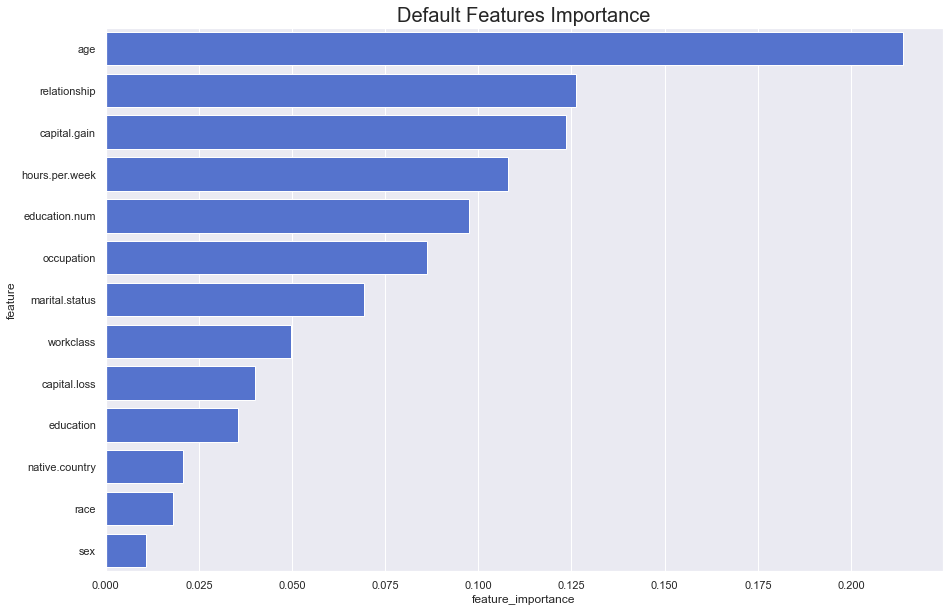

In [15]:
important_plot(base, 'Default Features Importance')

# Gaussian Naive Bayes Model

In [16]:
# model prediction accuracy
MODEL = GaussianNB()
MODEL.fit(train_features, train_labels)

predicts = MODEL.predict(test_features)
accuracy = accuracy_score(test_labels, predicts)
print(f"Accuracy = {accuracy * 100:.2f}%")

Accuracy = 82.13%


# Evaluation

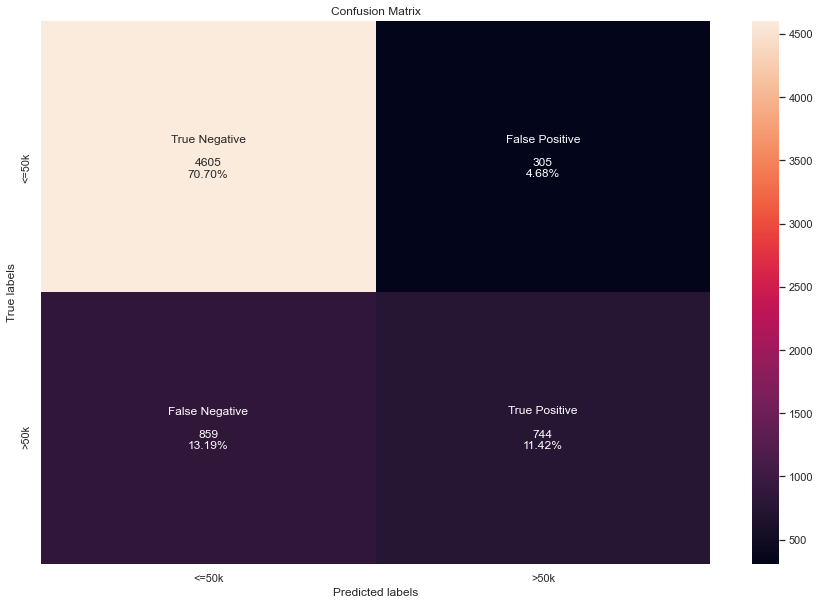

In [29]:
# Confusion Matrix
confusion_matrix = metrics.confusion_matrix(test_labels, predicts)

# Information
group_names  = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
group_counts = [f"{value:.0f}" for value in confusion_matrix.flatten()]

percentage = confusion_matrix.flatten() / np.sum(confusion_matrix)
group_percentages = [f"{value:.2%}" for value in percentage]

# Annotation Labels
annot_labels = [f"{v1}\n\n{v2}\n{v3}" for v1, v2, v3 in \
                zip(group_names, group_counts, group_percentages)]
annot_labels = np.asarray(annot_labels).reshape(2, 2)

# annot=True to annotate cells, ftm='g' to disable scientific notation
ax = plt.subplot()
sns.heatmap(confusion_matrix, annot=annot_labels, fmt="", ax=ax)

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

labels = ["<=50k", ">50k"]
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
plt.show()

In [18]:
report = metrics.classification_report(test_labels, predicts)
print(report)

              precision    recall  f1-score   support

           0       0.84      0.94      0.89      4910
           1       0.71      0.46      0.56      1603

    accuracy                           0.82      6513
   macro avg       0.78      0.70      0.72      6513
weighted avg       0.81      0.82      0.81      6513



# Save Model

In [ ]:
save_model(MODEL)